In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle

In [3]:
logs_df = pd.read_csv('logs.csv')

logs_df['Timestamp'] = pd.to_datetime(logs_df['Timestamp'], format='%d %B %Y at %H:%M')

logs_df['Date'] = logs_df['Timestamp'].dt.strftime('%Y-%m-%d')
logs_df['Time'] = logs_df['Timestamp'].dt.strftime('%H:%M')
logs_df['Day of the Week'] = logs_df['Timestamp'].dt.day_name()

logs_df.drop('Timestamp', axis=1, inplace=True)
logs_df.to_csv('processed_logs.csv', index=False)

logs_df


,Event Type,Date,Time,Day of the Week
0,OUT,2024-02-22,08:30,Thursday
1,IN,2024-02-22,16:48,Thursday
2,OUT,2024-02-22,18:05,Thursday
3,IN,2024-02-22,18:26,Thursday
4,OUT,2024-02-23,11:33,Friday
...,...,...,...,...
216,IN,2024-04-22,20:58,Monday
217,OUT,2024-04-23,11:35,Tuesday
218,IN,2024-04-23,14:12,Tuesday
219,OUT,2024-04-23,16:57,Tuesday


In [4]:
# Load data
data = pd.read_csv('processed_logs.csv')

def parse_datetime(row):
    return datetime.strptime(f"{row['Date']} {row['Time']}", "%Y-%m-%d %H:%M")

data['Datetime'] = data.apply(parse_datetime, axis=1)
data.sort_values(by='Datetime', inplace=True)

# Extract AWAY intervals 
def get_intervals(data):
    away_intervals = []
    temp_out = None
    for _, row in data.iterrows():
        if row['Event Type'] == 'OUT':
            temp_out = row['Datetime']
        elif row['Event Type'] == 'IN' and temp_out is not None:
            away_intervals.append((temp_out, row['Datetime']))
            temp_out = None
    return away_intervals

intervals = get_intervals(data)

# Generate hourly samples and label them
min_date = data['Datetime'].min().replace(hour=0, minute=0, second=0)
max_date = data['Datetime'].max().replace(hour=23, minute=59, second=59)
date_range = pd.date_range(start=min_date, end=max_date, freq='T') # T = minuTe
samples = pd.DataFrame(date_range, columns=['Datetime'])

# Determine if a given datetime is AWAY
def is_away(dt, intervals):
    for start, end in intervals:
        if start <= dt <= end:
            return 1 # AWAY
    return 0 # HOME

# label each sample as AWAY/HOME
samples['Away'] = samples['Datetime'].apply(lambda dt: is_away(dt, intervals))
samples['Hour'] = samples['Datetime'].dt.hour
samples['Day_of_Week'] = samples['Datetime'].dt.dayofweek

samples = pd.get_dummies(samples, columns=['Day_of_Week'])

# Prepare features & labels 
X = samples.drop(['Away', 'Datetime'], axis=1)
y = samples['Away']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Train a RandomForest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Evaluate the model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, predictions))

Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     13036
           1       0.61      0.39      0.47      4820

    accuracy                           0.77     17856
   macro avg       0.71      0.65      0.66     17856
weighted avg       0.75      0.77      0.75     17856



In [13]:
# Save the model
with open('user_activity_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved as user_activity_model.pkl")

Model saved as user_activity_model.pkl


In [14]:
# Load the model
with open('user_activity_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [15]:
# Verify the loaded model
loaded_predictions = loaded_model.predict(X_test)
loaded_accuracy = accuracy_score(y_test, loaded_predictions)
print(f'Loaded model accuracy: {loaded_accuracy:.2f}')

Loaded model accuracy: 0.77


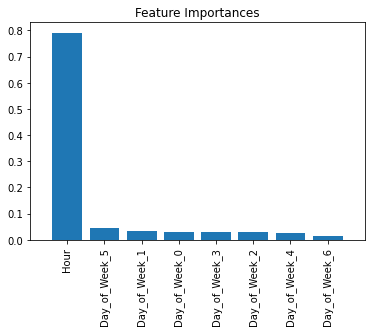

In [16]:
# Plot feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

/var/folders/_w/kl4xvqnd6_q9v746200yzqjw0000gn/T/ipykernel_37459/830069332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_data['Hour'] = tuesday_data['Datetime'].dt.hour


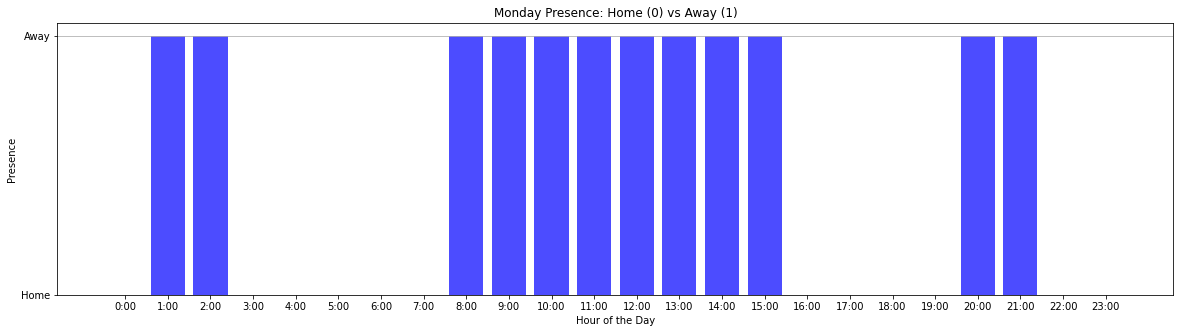

In [18]:
# Visualization
tuesday_data = samples[samples['Datetime'].dt.dayofweek == 0]  # 0-6: Mon-Sun
tuesday_data['Hour'] = tuesday_data['Datetime'].dt.hour
hours = tuesday_data['Hour'].unique()
away_status = [tuesday_data[tuesday_data['Hour'] == hour]['Away'].iloc[0] for hour in hours]

plt.figure(figsize=(20, 5))
plt.bar(hours, away_status, color='blue', alpha=0.7)
plt.title('Monday Presence: Home (0) vs Away (1)')
plt.xlabel('Hour of the Day')
plt.ylabel('Presence')
plt.xticks(hours, [f"{hour}:00" for hour in hours])
plt.yticks([0, 1], ['Home', 'Away'])
plt.grid(True, axis='y')
plt.show()